# Analysing: Characteristic IV curve of a RF generated magnetized plasma in low pressure

## Theory of probes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import scipy as sp

pd.set_option('display.precision', 10)

In [2]:
### IMPORT DOS DATA FRAMES
df_ref = pd.read_csv(r"C:\Users\Sinesio-PC\Desktop\28.06\ref9.csv",dtype = "float64")
#df_data = pd.read_csv(r"C:\Users\Sinesio-PC\Desktop\28.06\amp\10dbm2.csv", dtype = "float64") ### 44 W
#df_data = pd.read_csv(r"C:\Users\Sinesio-PC\Desktop\28.06\pressao\5sccm3.csv", dtype = "float64") ### Gas change
df_data = pd.read_csv(r"C:\Users\Sinesio-PC\Desktop\28.06\cmpom\1886a0.csv", dtype = "float64") ### With Magnetic Field
#df_data = pd.read_csv(r"C:\Users\Sinesio-PC\Desktop\28.06\sfitro\sf0.csv", dtype = "float64") ### Without filtering
### Convertendo a corrente R = 47K
df_ref["I"] = df_ref["CH2(V)"]/47e3
df_data["I"] = df_data["CH2(V)"]/47e3
# Mostrando os dataframes

df_data.head(),df_ref.head()

(   Time(s)    CH1(V)     CH2(V)             I
 0    -0.05 -16.65222  0.9228968  0.0000196361
 1    -0.05 -19.03110  0.4614484  0.0000098181
 2    -0.05 -21.40999  0.0000000  0.0000000000
 3    -0.05 -16.65222  0.9228968  0.0000196361
 4    -0.05 -21.40999  0.4614484  0.0000098181,
    Time(s)    CH1(V)   CH2(V)             I
 0    -0.05 -20.74216 -2.41059 -0.0000512891
 1    -0.05 -21.64399 -2.41059 -0.0000512891
 2    -0.05 -21.64399 -2.41059 -0.0000512891
 3    -0.05 -21.64399  0.00000  0.0000000000
 4    -0.05 -21.64399 -2.41059 -0.0000512891)

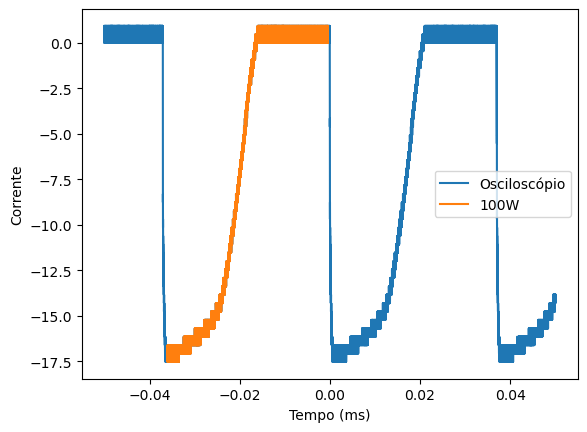

In [3]:
## Selecionando intervalo de medida.
df_curve_ref = df_ref.iloc[140000:495000]
df_curve = df_data.iloc[140000:495000]
## Visualização do osciloscópio (V x T)
plt.plot(df_data["Time(s)"],df_data["CH2(V)"], label = "Osciloscópio")
plt.plot(df_curve["Time(s)"],df_curve["CH2(V)"], label = "100W")
plt.xlabel("Tempo (ms)")
plt.ylabel("Corrente")
plt.legend()
plt.show()

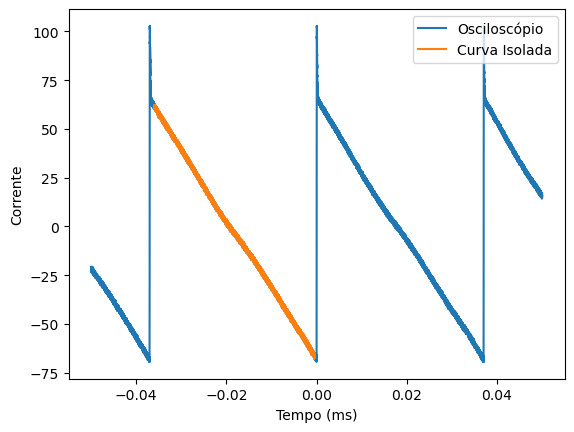

In [4]:
### Aplicando a correção 
plt.plot(df_ref["Time(s)"],df_ref["CH1(V)"], label = "Osciloscópio")
plt.plot(df_curve_ref["Time(s)"],df_curve_ref["CH1(V)"], label = "Curva Isolada")
plt.xlabel("Tempo (ms)")
plt.ylabel("Corrente")
plt.legend()
plt.show()

In [5]:
#### Checando se a ref e a curva estão com o mesmo numero de pontos
len(df_curve_ref), len(df_curve)

### Fazendo correção

#df_curve["I_compesated"] = (df_curve["I"]-df_ref["I"])*-1
df_curve["I_compesated"] = (df_curve["I"])*-1

C:\Users\Sinesio-PC\AppData\Local\Temp\ipykernel_25272\744691166.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve["I_compesated"] = (df_curve["I"])*-1


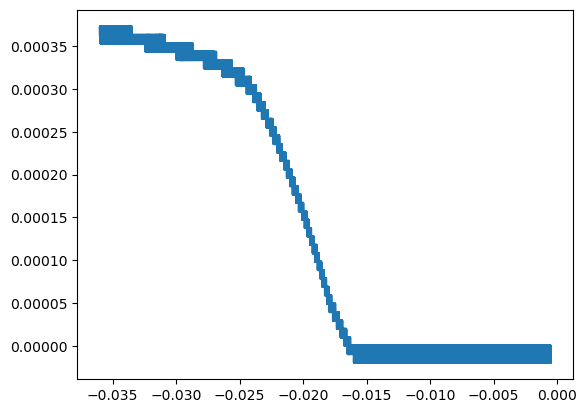

In [6]:
plt.plot(df_curve["Time(s)"],df_curve["I_compesated"])

In [7]:
### Definindo arrays para executar a filtragem
tempo = df_curve['Time(s)'].values
tensao = df_curve['CH1(V)'].values
corrente = df_curve['I_compesated'].values


In [8]:
### Definição do período 
dt = np.mean(np.diff(tempo)) ### intervalo de tempo
fs = 1.0/dt
f_corte = 100000 ### Frequência de corte
N = 3

### Filtragem do sinal

b, a = sp.signal.butter(N, f_corte/fs, btype='low')
tensao_filtrado = sp.signal.filtfilt(b, a, tensao)
corrente_filtrada = sp.signal.filtfilt(b,a, corrente)


df_curve["I_smooth"] = corrente_filtrada
df_curve["V_smooth"] = tensao_filtrado


C:\Users\Sinesio-PC\AppData\Local\Temp\ipykernel_25272\3804176565.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve["I_smooth"] = corrente_filtrada
C:\Users\Sinesio-PC\AppData\Local\Temp\ipykernel_25272\3804176565.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve["V_smooth"] = tensao_filtrado


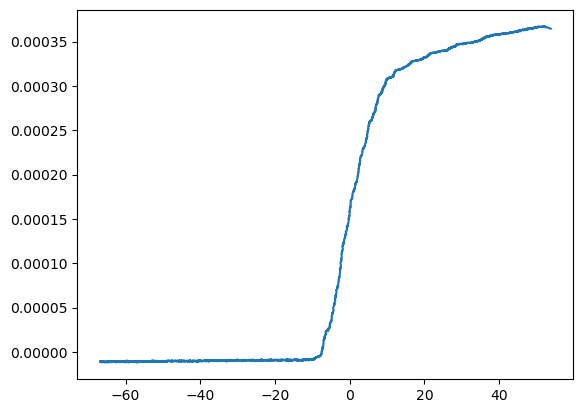

In [9]:
plt.plot(df_curve["V_smooth"],df_curve["I_smooth"])
plt.show()

# Adjusting the langmuir curve

In [31]:
df = df_curve[(df_curve["V_smooth"] > 8) & (df_curve["V_smooth"] < 20)] ### Sets a new dataframe with the interval of analysis


Índices de cruzamento: [196174]
Potenciais de cruzamento: [-7.50601461]
potencial de plasma :9.93 
 Vf: -7.51 
 Eletronic saturation current: 3.079e-04


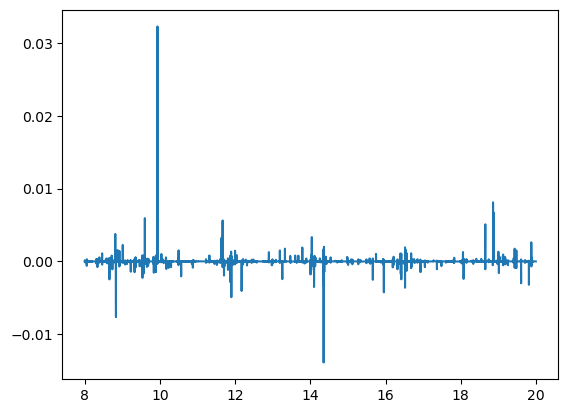

In [32]:
V_total = df_curve["V_smooth"]
I_total = df_curve["I_smooth"]

### looking for the V_p and Ies
I = np.array(df["I_smooth"])
V = np.array(df["V_smooth"])

# Detectar onde há mudança de sinal
positive =  np.where(V > 0)[0]
                      
crossings = np.where((np.diff(np.sign(df_curve["I_smooth"])) != 0))[0]

I_derivada = I[positive]

print("Índices de cruzamento:", crossings)

# Tensão no cruzamento (média entre os dois pontos vizinhos)
V_cross = (np.array(df_curve["V_smooth"])[crossings] + np.array(df_curve["V_smooth"])[crossings+1]) / 2
print("Potenciais de cruzamento:", V_cross)

vf = V_cross.mean()

dy_dx = np.zeros_like(I)
for i in range(1, len(I_derivada)-1):
    dy_dx[i] = (I_derivada[i+1] - I_derivada[i-1]) / (V[i+1] - V[i-1])
dy2_dx2 = np.gradient(dy_dx,V)

vp =  V[np.where(dy_dx == max(dy_dx))][0]
ies = I[np.where(dy_dx == max(dy_dx))][0]

print(f"potencial de plasma :{vp:.2f} \n Vf: {vf:.2f} \n Eletronic saturation current: {ies:.3e}")

#plt.plot(V,dy_dx)
plt.plot(V,dy_dx)

In [33]:
positive

array([    0,     1,     2, ..., 36648, 36649, 36650])

In [34]:
df.describe()

,Time(s),CH1(V),CH2(V),I,I_compesated,I_smooth,V_smooth,I_e
count,36651.0000000000,36651.0000000000,36651.0000000000,36651.0000000000,36651.0000000000,36651.0000000000,36651.0000000000,36651.0000000000
mean,-0.0254471128,13.7307100647,-14.8820177916,-0.0003166387,0.0003166387,0.0003166386,13.7306838131,0.0003284453
std,0.0010581019,4.0948134231,0.5971750721,0.0000127059,0.0000127059,0.0000115897,3.5342490095,0.0000115897
min,-0.0272800000,4.7577760000,-16.1506900000,-0.0003436317,0.0002847234,0.0002894283,8.0000847325,0.0003012349
25%,-0.0263630000,9.5155520000,-15.2278000000,-0.0003239957,0.0003043596,0.0003089661,10.4662624758,0.0003207728
50%,-0.0254470000,14.2733300000,-14.7663500000,-0.0003141777,0.0003141777,0.0003190389,13.7612545617,0.0003308456
75%,-0.0245310000,16.6522200000,-14.3049000000,-0.0003043596,0.0003239957,0.0003275824,16.7017009785,0.0003393890
max,-0.0236080000,23.7888800000,-13.3820000000,-0.0002847234,0.0003436317,0.0003328824,19.9974066492,0.0003446890


In [35]:
df["I_e"] = df["I_smooth"]-df["I_smooth"].min()
df_curve["I_e"] = df_curve["I_smooth"]-df_curve["I_smooth"].min()
df.head()

C:\Users\Sinesio-PC\AppData\Local\Temp\ipykernel_25272\831069075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["I_e"] = df["I_smooth"]-df["I_smooth"].min()
C:\Users\Sinesio-PC\AppData\Local\Temp\ipykernel_25272\831069075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve["I_e"] = df_curve["I_smooth"]-df_curve["I_smooth"].min()


,Time(s),CH1(V),CH2(V),I,I_compesated,I_smooth,V_smooth,I_e
227203,-0.027280,21.40999,-15.68925,-0.0003338138,0.0003338138,0.0003323544,19.9974066492,0.0000429261
227204,-0.027280,21.40999,-15.68925,-0.0003338138,0.0003338138,0.0003323399,19.9944511590,0.0000429116
227205,-0.027279,16.65222,-15.68925,-0.0003338138,0.0003338138,0.0003323255,19.9915433578,0.0000428972
227206,-0.027279,21.40999,-15.22780,-0.0003239957,0.0003239957,0.0003323110,19.9886846925,0.0000428827
227207,-0.027279,21.40999,-15.68925,-0.0003338138,0.0003338138,0.0003322965,19.9858765637,0.0000428683


In [36]:
df_te = df_curve[(df_curve["V_smooth"] > vf) & (df_curve["V_smooth"] < vp)]
df_te.head(), df_te.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80009 entries, 256103 to 336174
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Time(s)       80009 non-null  float64
 1   CH1(V)        80009 non-null  float64
 2   CH2(V)        80009 non-null  float64
 3   I             80009 non-null  float64
 4   I_compesated  80009 non-null  float64
 5   I_smooth      80009 non-null  float64
 6   V_smooth      80009 non-null  float64
 7   I_e           80009 non-null  float64
dtypes: float64(8)
memory usage: 5.5 MB


(         Time(s)     CH1(V)    CH2(V)             I  I_compesated  \
 256103 -0.024390   7.136663 -14.76635 -0.0003141777  0.0003141777   
 256104 -0.024390   9.515552 -14.30490 -0.0003043596  0.0003043596   
 256105 -0.024389  11.894440 -14.30490 -0.0003043596  0.0003043596   
 256106 -0.024389   7.136663 -14.76635 -0.0003141777  0.0003141777   
 256107 -0.024389  11.894440 -14.30490 -0.0003043596  0.0003043596   
 
             I_smooth      V_smooth           I_e  
 256103  0.0003078509  9.9301811262  0.0003196576  
 256104  0.0003078497  9.9287324073  0.0003196563  
 256105  0.0003078483  9.9273020664  0.0003196550  
 256106  0.0003078470  9.9258904721  0.0003196536  
 256107  0.0003078455  9.9244979531  0.0003196522  ,
 None)

In [37]:
slope, intercept, r_value, p_value, std_err =sp.stats.linregress(df_te["V_smooth"], np.log(abs(df_te["I_e"])))
Te_fit = 1 / slope   # Te em eV se V em volts

In [38]:
Te_fit, np.exp(intercept)

(np.float64(6.6896865394116025), np.float64(0.00012046025584619024))

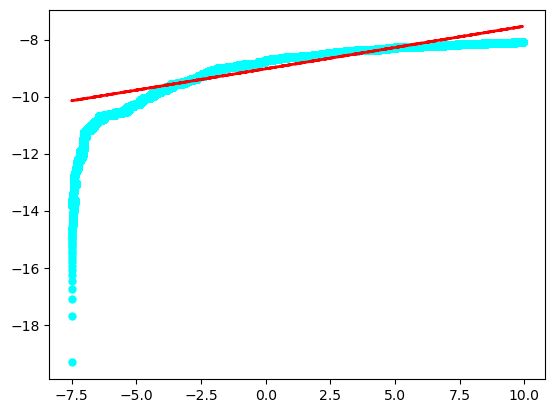

In [39]:
plt.scatter(df_te["V_smooth"],np.log(abs(df_te["I_smooth"])), lw = 0.01, color = "cyan" )
plt.plot(df_te["V_smooth"],intercept + slope*df_te["V_smooth"], lw = 2, ls = "--", color = "red")
plt.show()

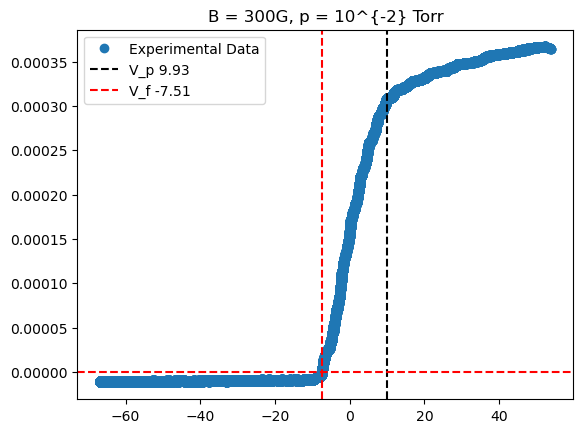

In [40]:
plt.plot(df_curve["V_smooth"],df_curve["I_smooth"], "o" ,label = "Experimental Data")
plt.axvline(vp, ls = "--" ,color = "black" , label = f"V_p {vp:.2f}")
plt.axvline(vf, ls = "--" ,color = "red", label = f"V_f {vf:.2f}")
plt.axhline(0, ls = "--", color = "red")
plt.title("B = 300G, p = 10^{-2} Torr")
plt.legend()
plt.savefig(r"C:\Users\Sinesio-PC\Desktop\28.06\curva.png")
plt.show()